In [7]:
from _bootstrap import PROJECT_ROOT, RESULTS_DIR, FIGURES_DIR, DEFAULT_SEEDS
from src.config import SimConfig, MetricsConfig
from src.experiments import run_sweep, summarize

import numpy as np
import matplotlib.pyplot as plt

In [8]:
SIM = SimConfig(
    N=300,
    steps=1500,
    save_every=30,
    attraction=0.08,       
    noise=0.03,             
    interaction_range=0.30,
)

MET = MetricsConfig(
    eps=0.06,
    bins=20,
    min_size=3,
    burn_frac=0.6,
)

In [9]:
noise_values = np.linspace(0.0, 0.08, 9)
seeds = DEFAULT_SEEDS

df_raw = run_sweep(
    SIM,
    MET,
    sweep_name="noise",
    sweep_values=noise_values,
    seeds=seeds,
)

df_sum = summarize(df_raw, by="noise")

raw_path = RESULTS_DIR / "noise_sweep_raw.csv"
sum_path = RESULTS_DIR / "noise_sweep_summary.csv"

df_raw.to_csv(raw_path, index=False)
df_sum.to_csv(sum_path, index=False)

df_sum.head()

,noise,nn_mean_mean,nn_mean_std,densvar_mean_mean,densvar_mean_std,lcf_mean_mean,lcf_mean_std,nclusters_mean_mean,nclusters_mean_std,lcf_time_std_mean,lcf_time_std_std,runtime_sec_mean,runtime_sec_std
0,0.00,0.010103,0.000618,25.890178,4.327020,0.765667,0.177674,1.700,0.483046,4.440892e-17,5.733167e-17,5.506961,0.232734
1,0.01,0.006477,0.000661,24.446311,4.464851,0.856983,0.189257,1.405,0.512320,7.264832e-05,2.297341e-04,5.407007,0.127251
2,0.02,0.008891,0.001189,16.341289,3.503927,0.866517,0.172177,2.155,0.915135,2.647558e-02,7.552644e-02,5.411715,0.120500
3,0.03,0.011341,0.000117,11.229422,0.207262,0.987567,0.001637,4.180,0.378006,6.260133e-03,1.281233e-03,5.529773,0.142748
4,0.04,0.017120,0.000229,5.699244,0.140922,0.945883,0.001741,12.540,0.464758,1.859346e-02,4.317258e-03,5.358970,0.140654


As noise strength increases, clustering is gradually disrupted: the largest cluster fraction decreases, nearest-neighbour distance increases, and density fluctuations are suppressed. Interestingly, intermediate noise levels enhance clustering, indicating that moderate stochasticity can facilitate collective aggregation. Moreover, time fluctuations of the largest cluster fraction peak near the transition, providing evidence for critical-like behaviour.

### Limiting cases: high-noise regime

To further validate the interpretation of the noise sweep, we inspect extreme noise values.
In the high-noise limit, stochastic fluctuations are expected to disrupt coherent structure,
leading to a more homogeneous spatial distribution.

We therefore visualize the final particle configuration for:
- very low noise (σ ≈ 0)
- very high noise (largest σ in the sweep)

This provides a qualitative sanity check complementary to the quantitative observables.

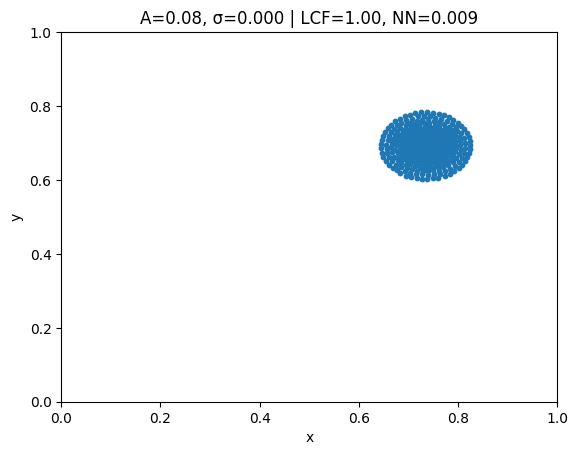

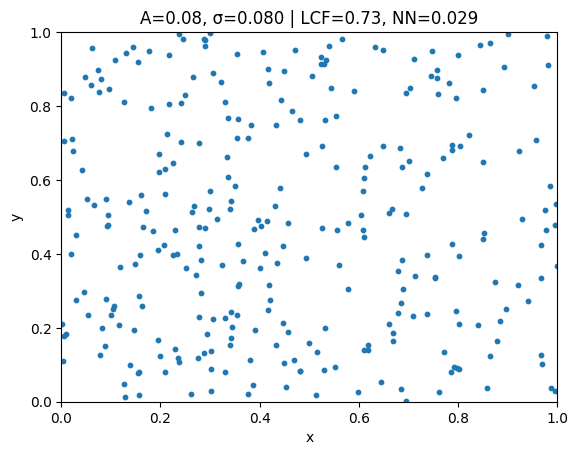

In [10]:
def plot_final_configuration(sigma, seed=0):
    """
    Qualitative sanity check: final configuration at given noise sigma.
    Uses current SIM/MET so parameters stay consistent with the sweep.
    """
    history = run_simulation(
        N=SIM.N,
        steps=SIM.steps,
        box_size=SIM.box_size,
        attraction=SIM.attraction,
        repulsion=SIM.repulsion,
        noise=float(sigma),
        seed=int(seed),
        save_every=SIM.steps,  # only keep final state
    )

    final_pos = history[-1]

    lcf = largest_cluster_fraction(final_pos, eps=MET.eps, box_size=SIM.box_size)
    nn  = nearest_neighbor_distance(final_pos, box_size=SIM.box_size)

    plt.figure()
    plt.scatter(final_pos[:, 0], final_pos[:, 1], s=10)
    plt.xlim(0, SIM.box_size)
    plt.ylim(0, SIM.box_size)
    plt.title(f"A={SIM.attraction:.2f}, σ={sigma:.3f} | LCF={lcf:.2f}, NN={nn:.3f}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

# visualize two extreme cases
plot_final_configuration(sigma=0.0, seed=0)
plot_final_configuration(sigma=noise_values[-1], seed=0)

At low noise, particles collapse into a compact cluster, consistent with a large largest-cluster fraction.
At high noise, the cluster is partially or fully disrupted, and particles spread over the domain.

This qualitative observation agrees with the trends observed in the noise sweep